## Net Cycle Flux Testing
#### Date: 5/24/2023

$\textbf{Objective:}$ The goal is to figure out why the net cycle flux for cycle 1 (EmrE) has a net cycle flux of zero across all values of $R_{\text{off}}$.

In [1]:
import numpy as np
import sympy
import networkx as nx
import matplotlib.pyplot as plt

from kda import calculations, diagrams, graph_utils 

In [2]:
def get_K(
    k31=1, k13=1, k57=1, k75=1, k42=1, k24=1, 
    k68=1, k86=1, k34=1, k43=1, k56=1, k65=1, 
    k12=1, k21=1, k78=1, k87=1, k71=1, k17=1, 
    k53=1, k35=1, k64=1, k46=1, k82=1, k28=1,
):
    K = np.array(
        [
            [0, k12, k13, 0, 0, 0, k17, 0],
            [k21, 0, 0, k24, 0, 0, 0, k28],
            [k31, 0, 0, k34, k35, 0, 0, 0],
            [0, k42, k43, 0, 0, k46, 0, 0],
            [0, 0, k53, 0, 0, k56, k57, 0],
            [0, 0, 0, k64, k65, 0, 0, k68],
            [k71, 0, 0, 0, k75, 0, 0, k78],
            [0, k82, 0, 0, 0, k86, k87, 0],
        ]
    )
    return K

def get_K_vals(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA):
    """
    k_EH_H : [1, 1e6] --- k13, k75
    k_ED_D : [1e-2, 1e4] --- k43, k65
    k_EHD_H : [1, 1e6] --- k24, k86
    k_EHD_D : [1e-2, 1e4] --- k21, k87

    k_ED_D / k_EHD_D = k_EH_H / k_EHD_H
    """
    H_on = 1e10
    D_on = 1e7
    H_in = 10 ** (-6.5)
    H_out = 10 ** (-7.5)
    c_D = 25e-9

    K = get_K(
        k31=H_on * H_out,
        k13=k_EH_H,
        k57=H_on * H_in,
        k75=k_EH_H,
        k42=H_on * H_out,
        k24=k_EHD_H,
        k68=H_on * H_in,
        k86=k_EHD_H,
        k34=D_on * c_D,
        k43=k_ED_D,
        k56=D_on * c_D,
        k65=k_ED_D,
        k12=D_on * c_D,
        k21=k_EHD_D,
        k78=D_on * c_D,
        k87=k_EHD_D,
        k71=k_AA,
        k17=k_AA,
        k53=k_AA,
        k35=k_AA,
        k64=k_AA,
        k46=k_AA,
        k82=k_AA,
        k28=k_AA,
    )
    return K

def get_cycle_order(cycle_idx):
    # manually set the order to CCW
    if cycle_idx < 14:
        order = [6, 0]
    elif (cycle_idx >= 14) and (cycle_idx < 21):
        order = [0, 2]
    elif (cycle_idx >= 21) and (cycle_idx < 25):
        order = [7, 1]
    elif (cycle_idx >= 25) and (cycle_idx < 27):
        order = [2, 4]
    elif cycle_idx == 27:
        order = [4, 6]
    else:
        raise ValueError(f"Too many cycles detected. Expected 28, detected {len(all_cycles)}.")
    return order

def get_sigma_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, dir_edges):

    sigma_data = np.zeros((len(k_AA), len(k_EH_H)))
    for i, kAA in enumerate(k_AA): 
        for j, (EH_H, ED_D, EHD_H, EHD_D) in enumerate(zip(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D)):
            K_tmp = get_K_vals(k_EH_H=EH_H, k_ED_D=ED_D, k_EHD_H=EHD_H, k_EHD_D=EHD_D, k_AA=kAA)
            G_tmp = nx.MultiDiGraph()
            graph_utils.generate_edges(G_tmp, K_tmp)

            sigma_data[i, j] = calculations.calc_sigma(
                G=G_tmp,
                dirpar_edges=dir_edges, 
                key="val", 
                output_strings=False,
            )
    return sigma_data

def get_net_cycle_flux_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, all_cycles):
    n_datasets = len(k_EH_H)
    n_cycles = len(all_cycles)
    n_kAA_vals = len(k_AA)
    pi_data = np.zeros((n_cycles, n_kAA_vals, n_datasets))
    sigma_K_data = np.zeros((n_cycles, n_kAA_vals, n_datasets))

    for i, cycle in enumerate(all_cycles):
        for j, kAA in enumerate(k_AA):
            for k, (EH_H, ED_D, EHD_H, EHD_D) in enumerate(zip(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D)):
                K_tmp = get_K_vals(k_EH_H=EH_H, k_ED_D=ED_D, k_EHD_H=EHD_H, k_EHD_D=EHD_D, k_AA=kAA)
                G_tmp = nx.MultiDiGraph()
                graph_utils.generate_edges(G_tmp, K_tmp)

                pi_data[i, j, k] = calculations.calc_pi_difference(
                    G=G_tmp, 
                    cycle=cycle, 
                    order=get_cycle_order(i), 
                    key="val", 
                    output_strings=False,
                )
                flux_diags = diagrams.generate_flux_diagrams(G=G_tmp, cycle=cycle)
                sigma_K_data[i, j, k] = calculations.calc_sigma_K(
                    G=G_tmp, 
                    cycle=cycle, 
                    flux_diags=flux_diags, 
                    key="val", 
                    output_strings=False,
                )
    return (pi_data, sigma_K_data)

def plot_cycle_data(x, y_arr, cycle_idx, logy=False, max_logx=1):
    fig = plt.figure(figsize=(8, 5), tight_layout=True)
    ax = fig.add_subplot(111)

    def get_ls_lw(i):
        if i % 2 == 0:
            return ("-", 1)
        else:
            return ("--", 2)

    if logy:
        plotting_func = ax.loglog
    else:
        plotting_func = ax.semilogx

    for i, idx in enumerate(cycle_idx):
        ls, lw = get_ls_lw(i)
        plotting_func(
            x,
            y_arr[idx],
            ls=ls,
            lw=lw,
            label=f"Cycle {idx+1}",
        )

    ax.set_xlim(10 ** -max_logx, 10 ** max_logx)
    ax.axvline(x=1, ymin=0, ymax=1, ls="--", label=r"$R_{\mathrm{AA}}=1$", color="black")
    ax.set_xlabel(r"$R_{\mathrm{AA}}$")
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left", ncol=1)
    ax.grid(True)

Generate the diagram with arbitrary rates (i.e. 1):

In [3]:
K = get_K()
G = nx.MultiDiGraph()
graph_utils.generate_edges(G, K)
# collect all of the cycles
all_cycles = graph_utils.find_all_unique_cycles(G)

Create the $k_\text{AA}$ data:

In [4]:
n_datasets = 201

# favor antiport initially by using large EHD values first
k_EH_H = np.logspace(-2, 8, n_datasets)
k_EHD_H = np.logspace(-2, 8, n_datasets)[::-1]
k_ED_D = np.logspace(-4, 6, n_datasets)
k_EHD_D = np.logspace(-4, 6, n_datasets)[::-1]
k_AA = np.array([1, 10, 100, 1000])

R_off_H = k_EH_H / k_EHD_H
R_off_D = k_ED_D / k_EHD_D
# double check that we are getting identical arrays here
np.testing.assert_allclose(R_off_H, R_off_D)

In [5]:
# collect the directional edges from the generic G beforehand
# since the edges do not change when the rates are changed below
dir_edges = diagrams.generate_directional_diagrams(G, return_edges=True)

In [6]:
sigma_data = get_sigma_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, dir_edges=dir_edges)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


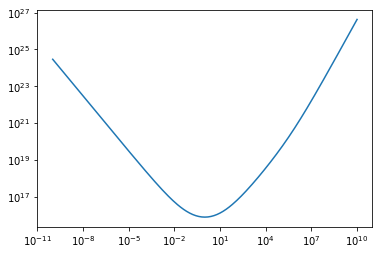

In [7]:
plt.loglog(R_off_H, sigma_data[0])

Now that we know $\Sigma$ is so incredibly large, lets take a look at the $\Pi_+$ and $\Pi_-$ values for cycles that go through all 8 states since they all have a $\Sigma_\text{K}$ of 1.

My $\textit{hypothesis}$ is the net cycle fluxes for these cycles will all be very close to zero $\textit{because}$ their $\Sigma_\text{K}$ values are 1. Cycle with flux diagrams likely have much higher net cycle flux numerators since many of the rates are very large, basically. 

In [8]:
pi_data, sigma_K_data = get_net_cycle_flux_data(k_EH_H, k_ED_D, k_EHD_H, k_EHD_D, k_AA, all_cycles=all_cycles)
num_data = pi_data * sigma_K_data
J_K_data = num_data/sigma_data

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 5, 4, 2, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 5, 4, 2, 3, 1]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycle [0, 6, 7, 1, 3, 5, 4, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 7, 1, 3, 5, 4, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycle [0, 6, 4, 5, 7, 1, 3, 2] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 5, 7, 1, 3, 2]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycle [0, 6, 4, 2, 3, 5, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 6, 4, 2, 3, 5, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycle [0, 2, 4, 6, 7, 5, 3, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 4, 6, 7, 5, 3, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycle [0, 2, 3, 5, 4, 6, 7, 1] contains all nodes in G. No flux diagrams generated.
No flux diagrams detected for cycle [0, 2, 3, 5, 4, 6, 7, 1]. Sigma K value is 1.
Cycl

The primary contributors to the operational flux near $R_\text{off} = 1$ are cycles 14 and 25.

In [9]:
print(J_K_data.shape)
# kAA = [1, 10, 100, 1000]
# we want the k_AA=100 case
k_AA_idx = 2

# cycle index definitions
all_cycle_idx = [i for i in range(len(all_cycles))]
zero_flux_cycle_idx = [4, 5, 6, 7, 8, 11, 14, 17, 20, 25, 26, 27]
nonzero_flux_cycle_idx = [i for i in all_cycle_idx if not i in zero_flux_cycle_idx]
anti_cycle_idx = [2, 3, 9, 10]
sym_cycle_idx = [15, 16, 22, 23]

(28, 4, 201)


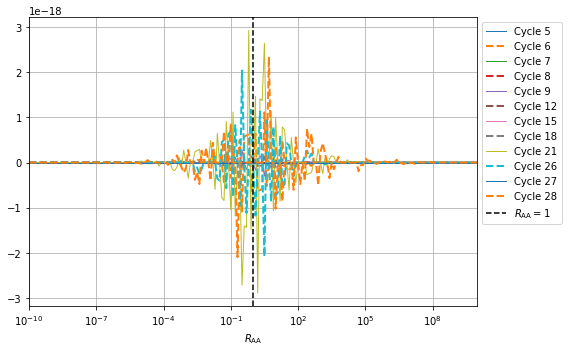

In [10]:
# zero net cycle flux cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=zero_flux_cycle_idx, logy=False, max_logx=10)

The following are all of the non-zero cycles. Only the symport and antiport cycles produce non-zero drug fluxes, so they are only relevant for the proton fluxes.

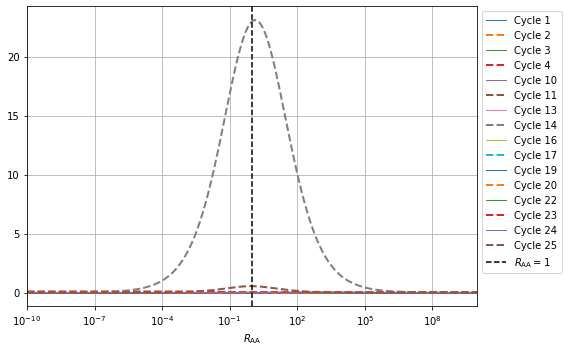

In [20]:
# non-zero cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=nonzero_flux_cycle_idx, logy=False, max_logx=10)

Here are the antiport cycles. They die off pretty quickly once $R_{\text{off}}$ increases past 1.

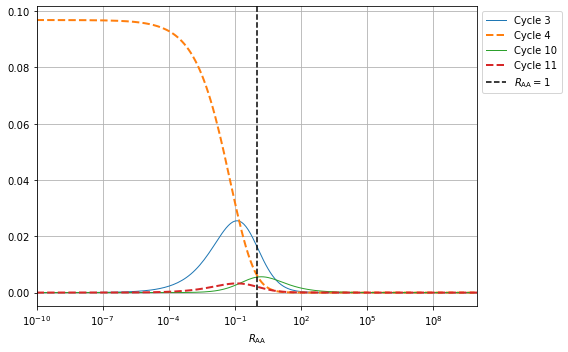

In [12]:
# antiport cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=anti_cycle_idx, logy=False, max_logx=10)

Here are the symport cycles. The only cycle here that contributes at the extreme is cycle 24

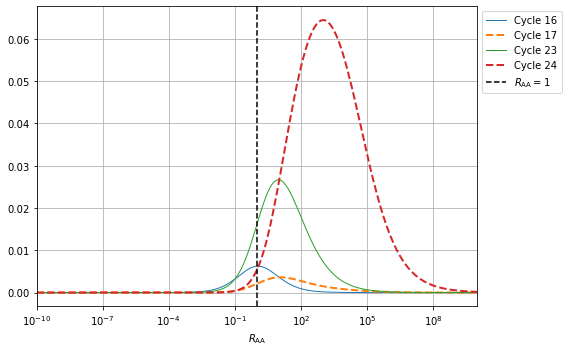

In [13]:
# symport cycles
plot_cycle_data(x=R_off_H, y_arr=J_K_data[:, k_AA_idx, :], cycle_idx=sym_cycle_idx, logy=False, max_logx=10)

### $\Pi_{+} - \Pi_{-}$ Analysis

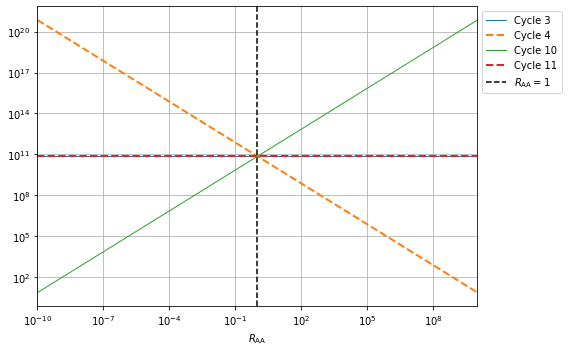

In [19]:
# antiport
plot_cycle_data(x=R_off_H, y_arr=pi_data[:, k_AA_idx, :], cycle_idx=anti_cycle_idx, logy=True, max_logx=10)

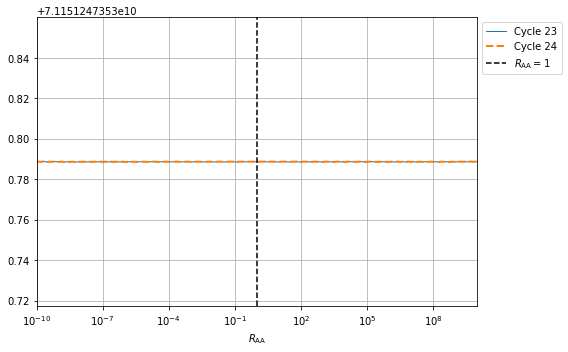

In [14]:
#symport
plot_cycle_data(x=R_off_H, y_arr=pi_data[:, k_AA_idx, :], cycle_idx=sym_cycle_idx[2:], logy=False, max_logx=10)

### $\Sigma_K$ Analysis

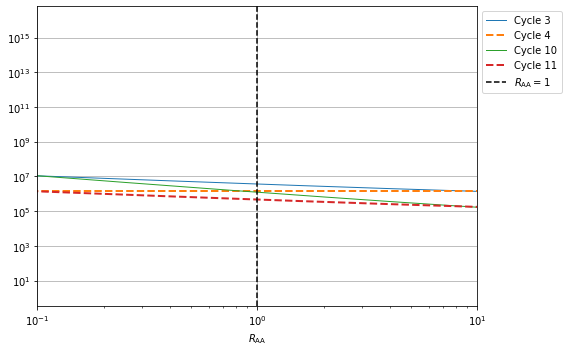

In [18]:
# antiport
plot_cycle_data(x=R_off_H, y_arr=sigma_K_data[:, k_AA_idx, :], cycle_idx=anti_cycle_idx, logy=True, max_logx=1)

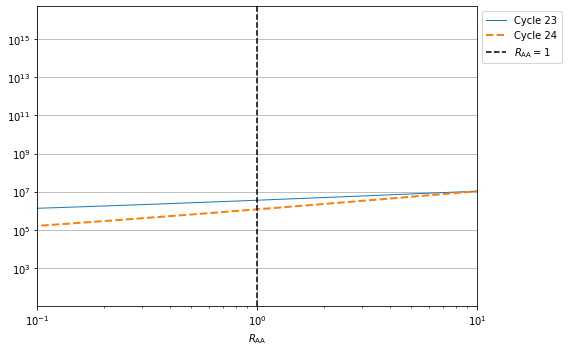

In [15]:
# symport
plot_cycle_data(x=R_off_H, y_arr=sigma_K_data[:, k_AA_idx, :], cycle_idx=sym_cycle_idx[2:], logy=True, max_logx=1)

### $\Sigma$ Analysis

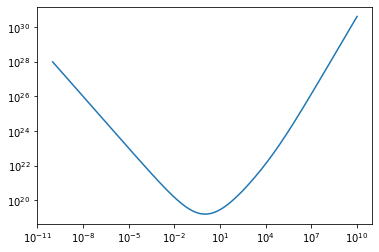

In [16]:
plt.loglog(R_off_H, sigma_data[k_AA_idx])